In [ ]:
!pip install -q kaggle

In [ ]:
!mkdir ~/.kaggle

In [ ]:
!cp kaggle.json ~/.kaggle

##Importing Kaggle Dataset

In [ ]:
!kaggle datasets download -d shashwatwork/identifying-disease-in-tea-leafs

 97% 721M/740M [00:06<00:00, 117MB/s]
100% 740M/740M [00:06<00:00, 121MB/s]


##Unzipping Kaggle Dataset

In [ ]:
!unzip /content/identifying-disease-in-tea-leafs.zip

Archive:  /content/identifying-disease-in-tea-leafs.zip
  inflating: tea sickness dataset/Anthracnose/IMG_20220503_143242.jpg  
  inflating: tea sickness dataset/Anthracnose/IMG_20220503_143328.jpg  
  inflating: tea sickness dataset/Anthracnose/IMG_20220503_143336.jpg  
  inflating: tea sickness dataset/Anthracnose/IMG_20220503_143344.jpg  
  inflating: tea sickness dataset/Anthracnose/IMG_20220503_143352.jpg  
  inflating: tea sickness dataset/Anthracnose/IMG_20220503_143401.jpg  
  inflating: tea sickness dataset/Anthracnose/IMG_20220503_143424.jpg  
  inflating: tea sickness dataset/Anthracnose/IMG_20220503_143433.jpg  
  inflating: tea sickness dataset/Anthracnose/IMG_20220503_143441.jpg  
  inflating: tea sickness dataset/Anthracnose/IMG_20220503_143451.jpg  
  inflating: tea sickness dataset/Anthracnose/IMG_20220503_143501.jpg  
  inflating: tea sickness dataset/Anthracnose/IMG_20220503_143511.jpg  
  inflating: tea sickness dataset/Anthracnose/IMG_20220503_143525.jpg  
  inflat

##Train & Test Split of Data

In [ ]:
!mkdir tea_train_test

In [ ]:
#importing Data Splitting Library
!pip install split-folders==0.3.1

In [ ]:
import split_folders

# Split with a ratio.
# To only split into training and validation set, set a tuple to `ratio`, i.e, `(.8, .2)`.
split_folders.ratio('/content/tea sickness dataset', output="/content/tea_train_test", seed=1337, ratio=(.8, .2)) # default values

Copying files: 885 files [00:03, 291.99 files/s]


##Importing Libraries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import PIL

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from sklearn.metrics import classification_report
import pathlib

##Loading Dataset

In [ ]:
dataset_path = "/content/tea sickness dataset"
dataset_dir = pathlib.Path(dataset_path)

In [ ]:
# list of sub directory(class)

class_names = []
for root, dirs, files in os.walk(dataset_path):
    if len(root) > len(dataset_path):
        x_class = os.path.relpath(root, dataset_path)
        class_names.append(x_class)

print(class_names)

['red leaf spot', 'algal leaf', 'gray light', 'healthy', 'brown blight', 'Anthracnose', 'bird eye spot', 'white spot']


In [ ]:
# print total number of images in the dataset
for class_i in class_names:
    image_count = len(list(dataset_dir.glob(f'{class_i}/*.jpg')))
    print(f"Images in class {class_i}:",image_count)

Images in class red leaf spot: 143
Images in class algal leaf: 113
Images in class gray light: 100
Images in class healthy: 74
Images in class brown blight: 113
Images in class Anthracnose: 100
Images in class bird eye spot: 100
Images in class white spot: 142


In [ ]:
# Parameter setting
train_batch = 128
val_batch = 128
img_height = 224
img_width = 224
IMG_SIZE = (img_height, img_width)
val_split = 0.2

# Load the training dataset
train_ds = tf.keras.utils.image_dataset_from_directory(
    dataset_path,
    validation_split=val_split,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=train_batch
)

Found 885 files belonging to 8 classes.
Using 708 files for training.


In [ ]:
# Load data for Validation
val_ds = tf.keras.utils.image_dataset_from_directory(dataset_dir,
                                                     validation_split=val_split,
                                                     subset="validation",
                                                     seed=123,
                                                     image_size=(img_height, img_width),
                                                     batch_size=val_batch
                                                    )

Found 885 files belonging to 8 classes.
Using 177 files for validation.


In [ ]:
class_names = train_ds.class_names
print(class_names)

num_classes=len(class_names)

['Anthracnose', 'algal leaf', 'bird eye spot', 'brown blight', 'gray light', 'healthy', 'red leaf spot', 'white spot']


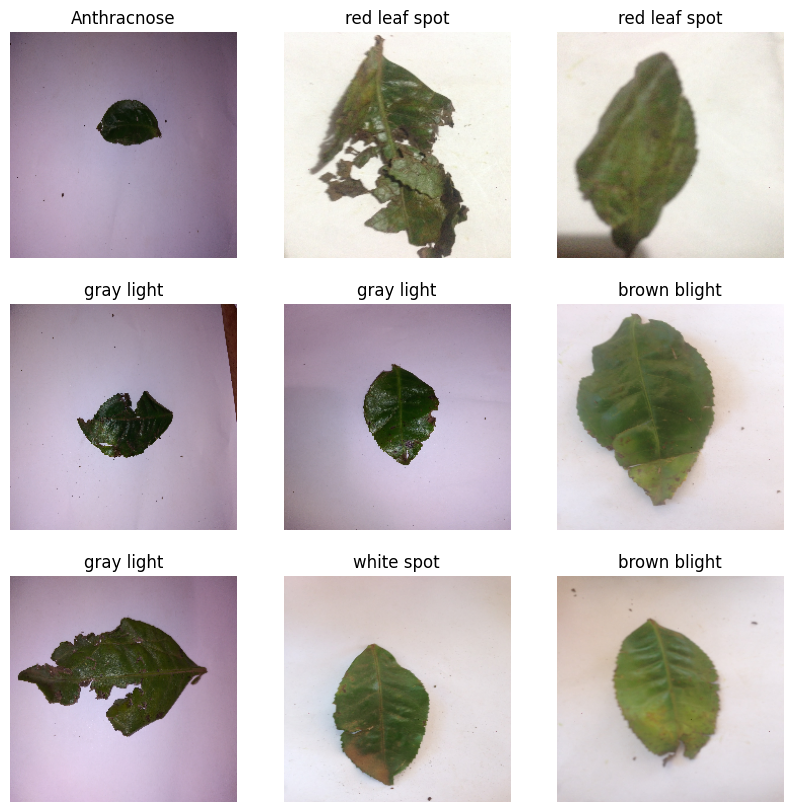

In [ ]:
# Review dataset sample
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

##Data Preprocessing

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

##**CNN Model Building**

In [ ]:
#Data augmentation layers to increase data variation for training
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal",input_shape=(img_height,img_width,3)),
    layers.RandomFlip("vertical"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
])

In [ ]:
# Model architecture
cnn_model = Sequential([
    data_augmentation,
    layers.Rescaling(1./255),
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(32, activation='relu'),
    layers.Dense(32, activation='relu'),
    layers.Dropout(0.3),
    layers.BatchNormalization(),
    layers.Dense(32, activation='relu'),
    layers.Dropout(0.3),
    layers.BatchNormalization(),
    layers.Dense(num_classes)   #num_classes=len(class_names) i.e 8
])

In [ ]:
# compile model
base_learning_rate = 0.0005
cnn_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
# display model
cnn_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 rescaling (Rescaling)       (None, 224, 224, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 224, 224, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 112, 112, 16)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 16)      2320      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 56, 56, 16)        0         
 g2D)                                                 

##CNN Model Training

In [ ]:
epochs=300
history = cnn_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    verbose=0
)

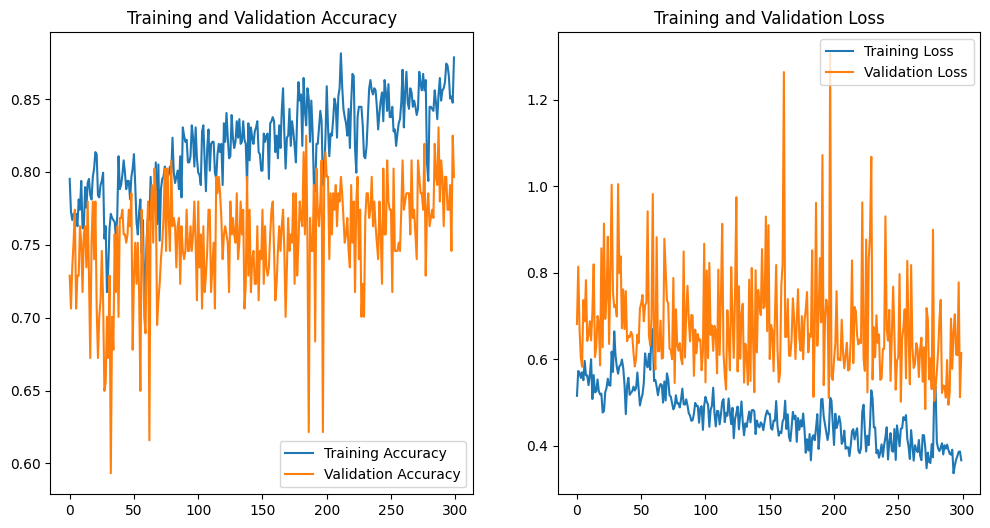

In [ ]:
# Check training result
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

##Model Evaluation

Predictions:
 [7 7 0 7 4 7 2 1 1 4 4 3 7 6 0 1 0 3 3 4 3 4 6 3 7 4 1 1 4 0 3 5 3 0 6 4 3
 1 4 4 7 7 6 0 4 2 6 3 1 7 6 0 3 4 4 3 7 1 5 0 6 4 0 4 1 6 4 6 3 5 3 7 3 4
 2 7 1 3 2 0 2 6 6 0 0 1 1 4 7 0 4 4 5 3 2 6 4 7 7 7 2 6 0 7 4 1 3 3 5 6 5
 5 7 6 1 3 2 3 7 0 3 4 3 4 4 1 3 4]
Labels:
 [3 7 2 7 0 7 2 1 1 4 0 7 7 6 0 1 2 3 3 4 3 0 6 3 7 4 1 1 0 4 7 5 3 0 6 4 3
 7 4 4 7 7 6 2 0 4 6 3 1 3 6 2 7 4 4 3 7 1 5 0 6 4 0 4 1 6 4 6 3 5 3 7 3 2
 2 7 1 3 2 0 4 6 6 0 0 1 1 4 7 0 0 4 5 3 2 6 4 7 7 3 2 6 0 7 4 1 3 3 5 6 5
 5 7 6 1 3 2 3 7 0 3 4 3 0 4 7 3 0]

              precision    recall  f1-score   support

           0       0.67      0.56      0.61        18
           1       0.87      1.00      0.93        13
           2       0.75      0.55      0.63        11
           3       0.87      0.87      0.87        23
           4       0.65      0.85      0.74        20
           5       1.00      1.00      1.00         7
           6       1.00      1.00      1.00        15
           7       0.

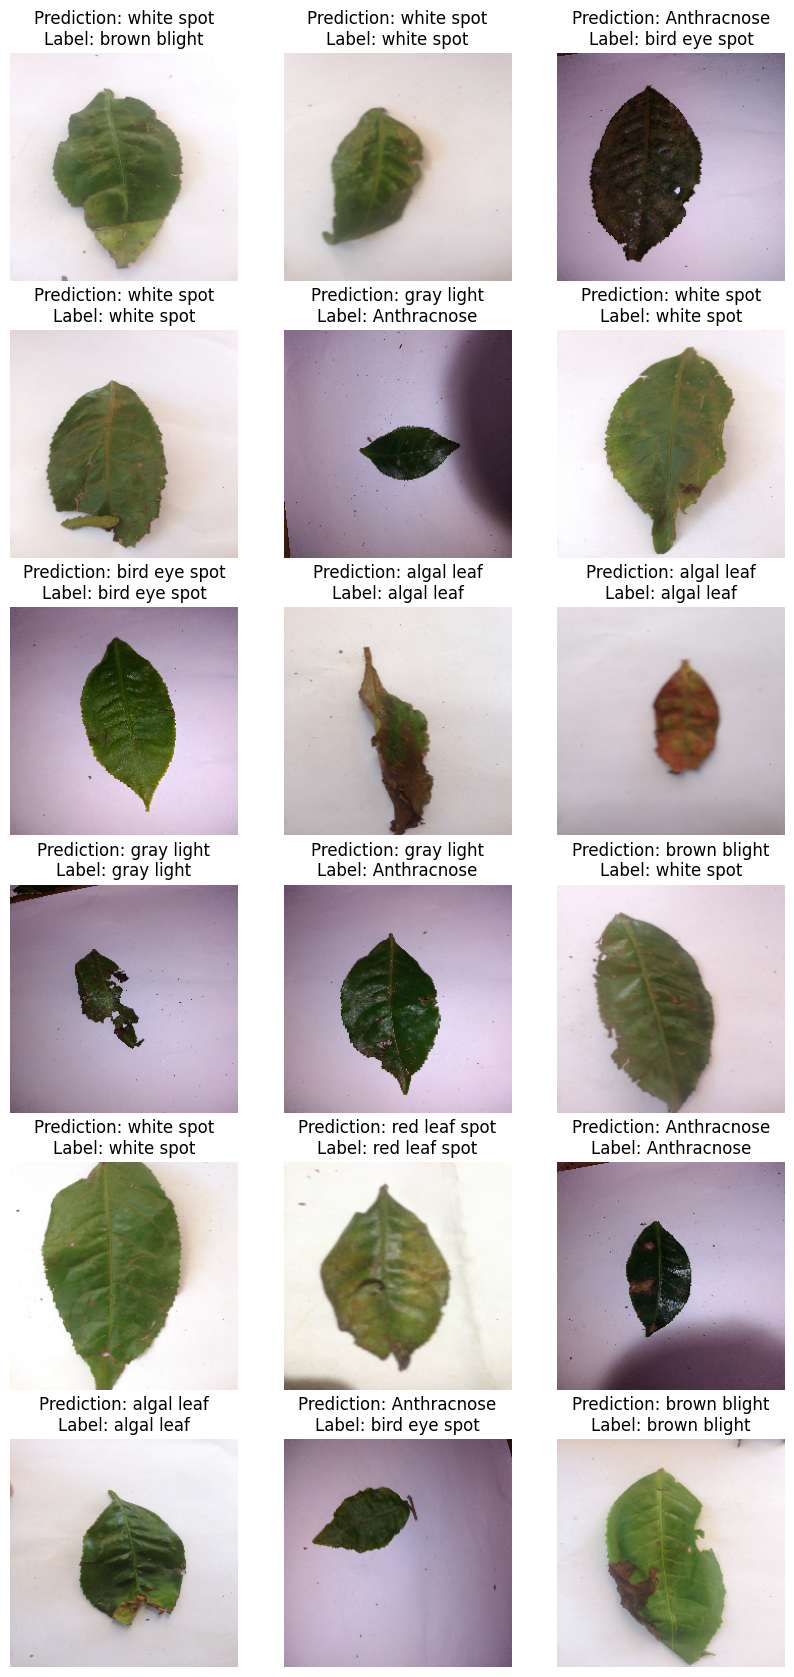

In [ ]:
# Retrieve a batch of images from the test set
image_batch, label_batch = val_ds.as_numpy_iterator().next()
predictions = cnn_model.predict_on_batch(image_batch)

class_predictions = []
for i in predictions:
    class_prediction = np.argmax(i)
    class_predictions.append(class_prediction)

class_predictions = np.array(class_predictions)
print('Predictions:\n', class_predictions)
print('Labels:\n', label_batch)
print()
print(classification_report(label_batch, class_predictions))

plt.figure(figsize=(10, 21))
for i in range(18):
    ax = plt.subplot(6, 3, i + 1)
    plt.imshow(image_batch[i].astype("uint8"))
    plt.title("Prediction: "+class_names[class_predictions[i]]+"\nLabel: "+class_names[label_batch[i]])
    plt.axis("off")

##The CNN Model shows a Testing Accuracy of 81%

##Model Testing

In [ ]:
from tensorflow.keras.preprocessing import image

# testing 1
img = image.load_img('/content/tea sickness dataset/algal leaf/UNADJUSTEDNONRAW_thumb_19.jpg',target_size =(224,224))

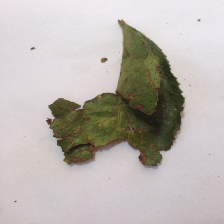

In [ ]:
img

In [ ]:
x = image.img_to_array(img)
x = np.expand_dims(x,axis = 0)
pred =np.argmax(cnn_model.predict(x))
op =['Anthracnose','algal leaf','bird eye spot','brown blight','gray light','healthy','red leaf spot','white spot']
op[pred]


1/1 [==============================] - 0s 32ms/step


'algal leaf'

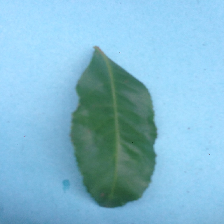

In [ ]:
#testing-2
img2 = image.load_img('/content/tea_train_test/val/healthy/UNADJUSTEDNONRAW_thumb_21f.jpg',target_size =(224,224))
img2

In [ ]:
y = image.img_to_array(img2)
y = np.expand_dims(y,axis = 0)
pred =np.argmax(cnn_model.predict(y))
op =['Anthracnose','algal leaf','bird eye spot','brown blight','gray light','healthy','red leaf spot','white spot']
op[pred]

1/1 [==============================] - 0s 27ms/step


'healthy'

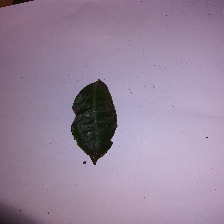

In [ ]:
#Testing-3
img3 = image.load_img('/content/tea_train_test/val/gray light/IMG_20220503_140914.jpg',target_size =(224,224))
img3

In [ ]:
x = image.img_to_array(img3)
x = np.expand_dims(x,axis = 0)
pred =np.argmax(cnn_model.predict(x))
op =['Anthracnose','algal leaf','bird eye spot','brown blight','gray light','healthy','red leaf spot','white spot']
op[pred]

1/1 [==============================] - 0s 30ms/step


'gray light'

In [ ]:
#Predictions v/s Labels
compare = pd.DataFrame({'Labels':label_batch,'Prediction':class_predictions})
compare

Labels  Prediction
0         3           7
1         7           7
2         2           0
3         7           7
4         0           4
..      ...         ...
123       0           4
124       4           4
125       7           1
126       3           3
127       0           4

[128 rows x 2 columns]

<Axes: >

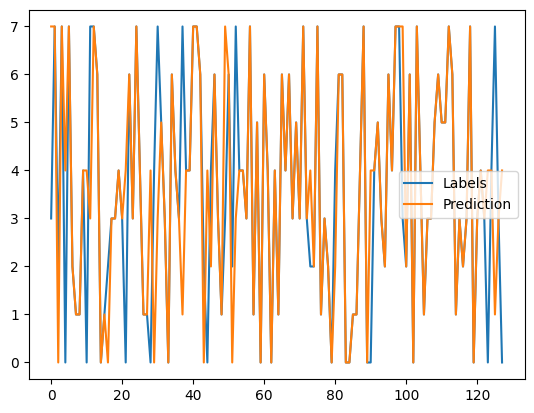

In [ ]:
compare.plot()

In [ ]:
cnn_model.save('CNN_Tea_Leaf_Disease_Detection.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


##Saving Model Histroy

In [ ]:
history_df = pd.DataFrame(history.history)
history_df.to_csv("cnn_history.csv")
history_df.tail()

loss  accuracy  val_loss  val_accuracy
295  0.367669  0.865819  0.611099      0.774011
296  0.375968  0.850282  0.609117      0.790960
297  0.385573  0.851695  0.777662      0.745763
298  0.386529  0.847458  0.512042      0.824859
299  0.365979  0.878531  0.614045      0.796610

##**Transfer Learning Based Tea Leaf Disease Detection**

##VGG16

In [ ]:
#Imporitng Libraries

from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Model

In [ ]:
#Removing the Last Layer from the model

vgg = VGG16(include_top = False,input_shape = (224,224,3))

58889256/58889256 [==============================] - 0s 0us/step


In [ ]:
#Checking Layers of VGG16 Model

for layer in vgg.layers:
  print(layer)

In [ ]:
len(vgg.layers)

19

In [ ]:
#Freezing the pre trained layers

for layer in vgg.layers:
  layer.trainable = False

In [ ]:
#Adding Flattening Layer before output layer
x= Flatten()(vgg.output)

In [ ]:
#Creating the output layer
output = Dense(8, activation ='softmax')(x)

In [ ]:
#Declaring the VGG Model
vgg16_model = Model(vgg.input,output)

In [ ]:
vgg16_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
vgg16_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),loss='categorical_crossentropy', metrics=['accuracy'])


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

"""# Define data generators for train and validation sets
train_datagen = ImageDataGenerator(rescale=1./255)  # Normalize pixel values to [0,1]
val_datagen = ImageDataGenerator(rescale=1./255)

# Define the directory containing your labeled data
train_dir = '/content/tea_train_test/train'

# Define batch size and image dimensions
batch_size = 32
image_size = (224, 224)

# Create data generators
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical'
)

# Assuming you have 8 labeled classes, set the number of classes accordingly
num_classes = 8

# Train your model
history = vgg16_model.fit(
    train_generator,
    epochs=5,
    steps_per_epoch=len(train_generator),
    class_weight=None,
    verbose=1
)"""

"# Define data generators for train and validation sets\ntrain_datagen = ImageDataGenerator(rescale=1./255)  # Normalize pixel values to [0,1]\nval_datagen = ImageDataGenerator(rescale=1./255)\n\n# Define the directory containing your labeled data\ntrain_dir = '/content/tea_train_test/train'\n\n# Define batch size and image dimensions\nbatch_size = 32\nimage_size = (224, 224)\n\n# Create data generators\ntrain_generator = train_datagen.flow_from_directory(\n    train_dir,\n    target_size=image_size,\n    batch_size=batch_size,\n    class_mode='categorical'\n)\n\n# Assuming you have 8 labeled classes, set the number of classes accordingly\nnum_classes = 8\n\n# Train your model\nhistory = vgg16_model.fit(\n    train_generator,\n    epochs=5,\n    steps_per_epoch=len(train_generator),\n    class_weight=None,\n    verbose=1\n)"

In [ ]:
# Define data generators for train and validation sets
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)

# Define batch size and image dimensions
batch_size = 15
image_size = (224, 224)

# Create data generators
train_generator = train_datagen.flow_from_directory(
    "/content/tea_train_test/train",
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    "/content/tea_train_test/val",
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical'
)

# Train the model with validation
history = vgg16_model.fit(
    train_generator,
    epochs=5,
    steps_per_epoch=len(train_generator),
    validation_data=val_generator,
    validation_steps=len(val_generator)
)

Found 706 images belonging to 8 classes.
Found 179 images belonging to 8 classes.
Epoch 1/5
48/48 [==============================] - 38s 721ms/step - loss: 1.8777 - accuracy: 0.2918 - val_loss: 1.4760 - val_accuracy: 0.4860
Epoch 2/5
48/48 [==============================] - 32s 656ms/step - loss: 1.2877 - accuracy: 0.5907 - val_loss: 1.1601 - val_accuracy: 0.6536
Epoch 3/5
48/48 [==============================] - 35s 741ms/step - loss: 0.9954 - accuracy: 0.7479 - val_loss: 0.9900 - val_accuracy: 0.7542
Epoch 4/5
48/48 [==============================] - 33s 688ms/step - loss: 0.8442 - accuracy: 0.7861 - val_loss: 0.8984 - val_accuracy: 0.7598
Epoch 5/5
48/48 [==============================] - 31s 650ms/step - loss: 0.7117 - accuracy: 0.8442 - val_loss: 0.8039 - val_accuracy: 0.7709


##The difference in accuracy between training and validation is 0.0733 i.e 7.33%

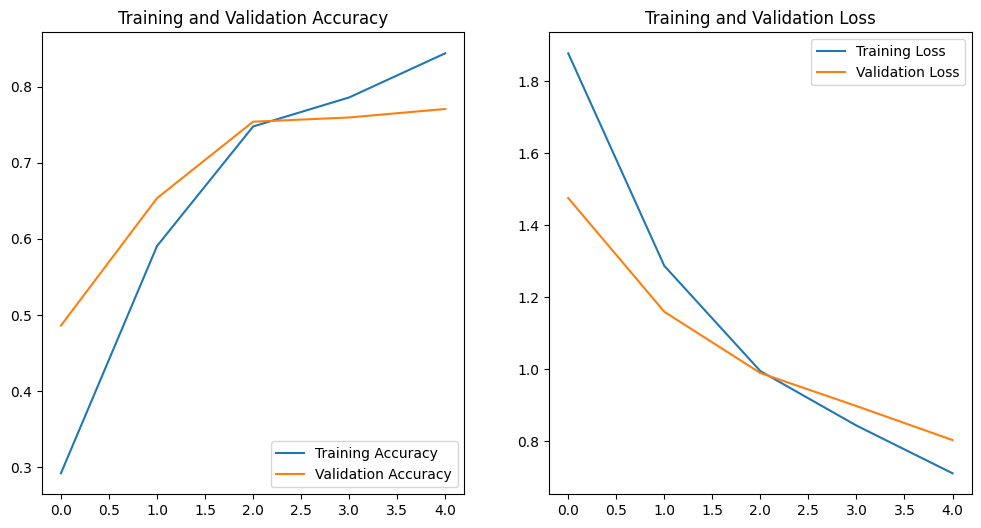

In [ ]:
# Check training result
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs=5

epochs_range = range(epochs)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

##Model Evaluation

Predictions:
 [1 2 2 1 2 1 2 1 4 4 2 1 7 1 0 1 0 1 1 2 2 2 6 1 1 4 1 1 4 4 1 5 2 0 6 4 2 2 4 4 2 1 1 2 0 4 2 4 1 1 3 2 4 4 4 1 2 1 5 2 2 4 0 2 1 2 4 6 2 5 2 1 2 2 2 1 1 1 2 2 4 1 1 0 0 1 1 4 1 0 0 4 5 1 2 2 4 2 2 1 2 1 0 1 4 1 2 3 1 6 5 0 1 1 1 1 2 3 1 4 3 4 0 0 4 1 4 0]
Labels:
 [3 7 2 7 0 7 2 1 1 4 0 7 7 6 0 1 2 3 3 4 3 0 6 3 7 4 1 1 0 4 7 5 3 0 6 4 3 7 4 4 7 7 6 2 0 4 6 3 1 3 6 2 7 4 4 3 7 1 5 0 6 4 0 4 1 6 4 6 3 5 3 7 3 2 2 7 1 3 2 0 4 6 6 0 0 1 1 4 7 0 0 4 5 3 2 6 4 7 7 3 2 6 0 7 4 1 3 3 5 6 5 5 7 6 1 3 2 3 7 0 3 4 3 0 4 7 3 0]

              precision    recall  f1-score   support

           0       0.79      0.61      0.69        18
           1       0.29      0.92      0.44        13
           2       0.29      0.91      0.44        11
           3       0.75      0.13      0.22        23
           4       0.75      0.90      0.82        20
           5       1.00      0.71      0.83         7
           6       1.00      0.27      0.42        15
           7       1.00    

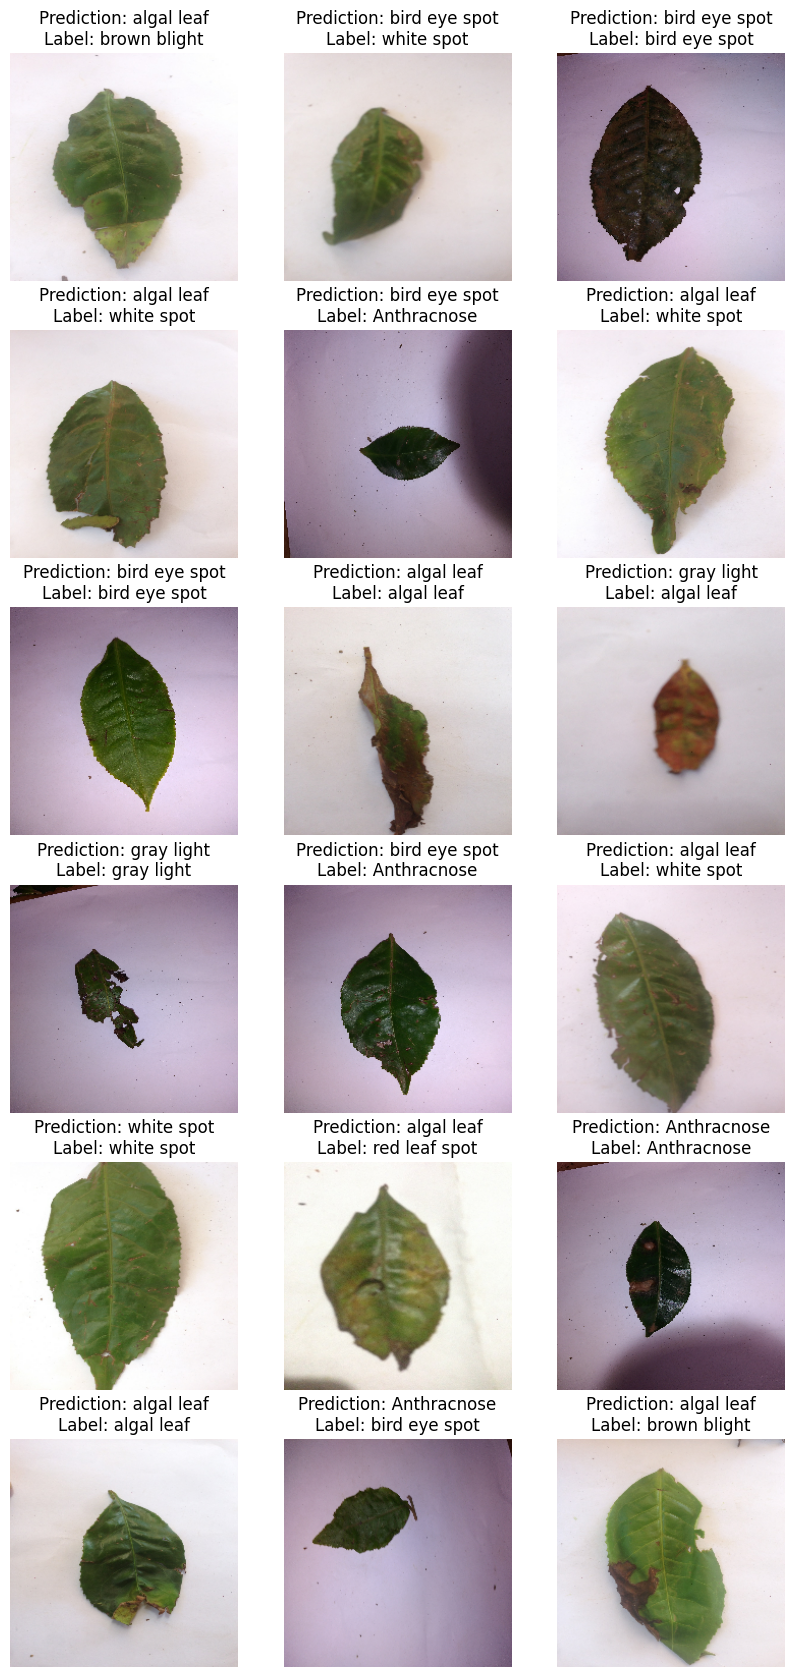

In [ ]:
# Retrieve a batch of images from the test set
image_batch, label_batch = val_ds.as_numpy_iterator().next()
predictions = vgg16_model.predict_on_batch(image_batch)

class_predictions = []
for i in predictions:
    class_prediction = np.argmax(i)
    class_predictions.append(class_prediction)

class_predictions = np.array(class_predictions)
print('Predictions:\n', class_predictions)
print('Labels:\n', label_batch)
print()
print(classification_report(label_batch, class_predictions))

plt.figure(figsize=(10, 21))
for i in range(18):
    ax = plt.subplot(6, 3, i + 1)
    plt.imshow(image_batch[i].astype("uint8"))
    plt.title("Prediction: "+class_names[class_predictions[i]]+"\nLabel: "+class_names[label_batch[i]])
    plt.axis("off")

##The VGG16 Model shows a Testing Accuracy of 50%

##Model Testing

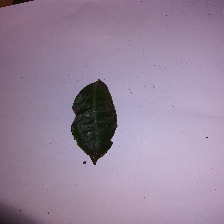

In [ ]:
img = image.load_img('/content/tea_train_test/val/gray light/IMG_20220503_140914.jpg',target_size =(224,224))
img

In [ ]:
x = image.img_to_array(img)
x = np.expand_dims(x,axis = 0)
pred =np.argmax(vgg16_model.predict(x))
op =['Anthracnose','algal leaf','bird eye spot','brown blight','gray light','healthy','red leaf spot','white spot']
op[pred]

1/1 [==============================] - 0s 251ms/step


'gray light'

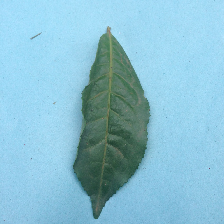

In [ ]:
img2 = image.load_img('/content/tea_train_test/val/healthy/UNADJUSTEDNONRAW_thumb_237.jpg',target_size =(224,224))
img2

In [ ]:
x = image.img_to_array(img2)
x = np.expand_dims(x,axis = 0)
pred =np.argmax(vgg16_model.predict(x))
op =['Anthracnose','algal leaf','bird eye spot','brown blight','gray light','healthy','red leaf spot','white spot']
op[pred]

1/1 [==============================] - 0s 84ms/step


'healthy'

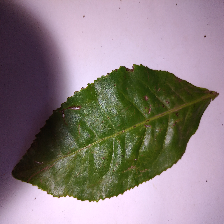

In [ ]:
img3 = image.load_img('/content/tea_train_test/val/bird eye spot/IMG_20220503_155800.jpg',target_size =(224,224))
img3

In [ ]:
x = image.img_to_array(img3)
x = np.expand_dims(x,axis = 0)
pred =np.argmax(vgg16_model.predict(x))
op =['Anthracnose','algal leaf','bird eye spot','brown blight','gray light','healthy','red leaf spot','white spot']
op[pred]

1/1 [==============================] - 0s 33ms/step


'bird eye spot'

In [ ]:
#Model Saving
vgg16_model.save('VGG16_Tea_Leaf_Disease_Detection.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
#Saving Model History
history_df = pd.DataFrame(history.history)
history_df.to_csv("vgg16_history.csv")
history_df.tail()

loss  accuracy  val_loss  val_accuracy
295  0.367669  0.865819  0.611099      0.774011
296  0.375968  0.850282  0.609117      0.790960
297  0.385573  0.851695  0.777662      0.745763
298  0.386529  0.847458  0.512042      0.824859
299  0.365979  0.878531  0.614045      0.796610

##**Resnet50 Transfer Learning**

In [ ]:
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Model

In [ ]:
resnet50 = ResNet50(include_top = False,input_shape = (224,224,3))

94765736/94765736 [==============================] - 1s 0us/step


In [ ]:
for layer in resnet50.layers:
  print(layer)

In [ ]:
len(resnet50.layers)

175

In [ ]:
for layer in resnet50.layers:
  layer.trainable = False

In [ ]:
x = Flatten()(resnet50.output)

In [ ]:
output = Dense(8,activation = 'softmax')(x)

In [ ]:
resnet50_model =Model(resnet50.input,output)

In [ ]:
resnet50_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_2[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                        

In [ ]:
resnet50_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),loss='categorical_crossentropy', metrics=['accuracy'])


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
# Define data generators for train and validation sets
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)

# Define batch size and image dimensions
batch_size = 25
image_size = (224, 224)

# Create data generators
train_generator = train_datagen.flow_from_directory(
    "/content/tea_train_test/train",
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    "/content/tea_train_test/val",
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical'
)

# Train the model with validation
history = resnet50_model.fit(
    train_generator,
    epochs=10,
    steps_per_epoch=len(train_generator),
    validation_data=val_generator,
    validation_steps=len(val_generator)
)

Found 706 images belonging to 8 classes.
Found 179 images belonging to 8 classes.
Epoch 1/10
29/29 [==============================] - 41s 1s/step - loss: 1.1324 - accuracy: 0.6898 - val_loss: 1.3489 - val_accuracy: 0.6034
Epoch 2/10
29/29 [==============================] - 29s 1s/step - loss: 0.6108 - accuracy: 0.7847 - val_loss: 1.1227 - val_accuracy: 0.6648
Epoch 3/10
29/29 [==============================] - 31s 1s/step - loss: 0.4576 - accuracy: 0.8215 - val_loss: 1.1067 - val_accuracy: 0.6257
Epoch 4/10
29/29 [==============================] - 32s 1s/step - loss: 0.3917 - accuracy: 0.8442 - val_loss: 1.1614 - val_accuracy: 0.6592
Epoch 5/10
29/29 [==============================] - 29s 1s/step - loss: 0.4066 - accuracy: 0.8513 - val_loss: 0.8725 - val_accuracy: 0.7039
Epoch 6/10
29/29 [==============================] - 32s 1s/step - loss: 0.4079 - accuracy: 0.8272 - val_loss: 0.9415 - val_accuracy: 0.6704
Epoch 7/10
29/29 [==============================] - 29s 1s/step - loss: 0.4608

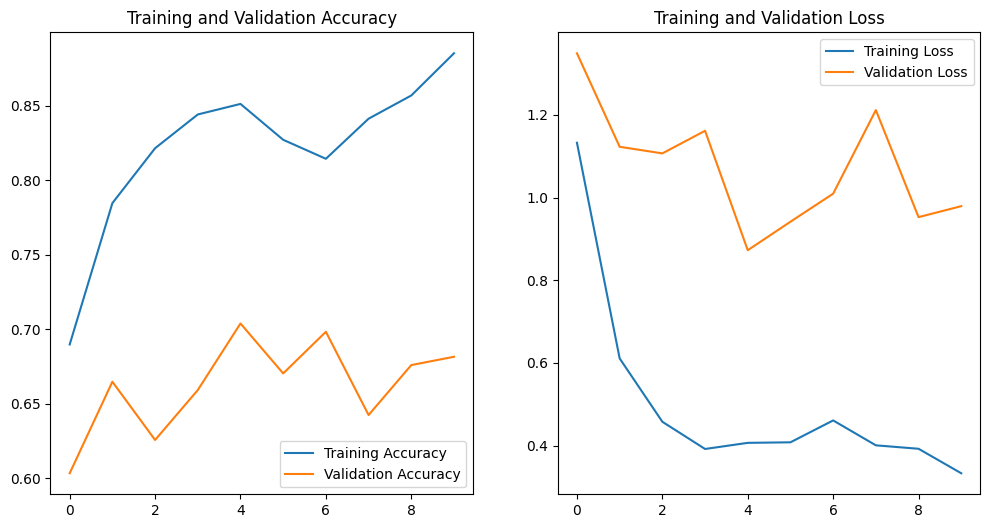

In [ ]:
# Check training result
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs=10

epochs_range = range(epochs)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
#Model Saving
resnet50_model.save('ResNet50_Tea_Leaf_Disease_Detection.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
#Saving Model History
history_df = pd.DataFrame(history.history)
history_df.to_csv("resnet50_history.csv")
history_df.tail()

loss  accuracy  val_loss  val_accuracy
5  0.407869  0.827195  0.941469      0.670391
6  0.460820  0.814448  1.009294      0.698324
7  0.400578  0.841360  1.211543      0.642458
8  0.392240  0.856941  0.952534      0.675978
9  0.332964  0.885269  0.979116      0.681564

##Model Evaluation

Predictions:
 [4 2 0 0 2 2 4 2 2 0 0 2 0 4 0 2 4 2 4 4 2 0 4 0 2 2 2 0 0 2 4 4 2 0 4 0 0 4 2 2 4 4 4 0 2 2 4 2 2 4 4 0 0 2 2 2 2 0 4 0 4 4 4 2 2 0 0 4 0 4 0 0 4 2 0 4 0 4 4 2 4 4 2 4 0 4 2 4 0 2 2 0 2 4 2 0 2 0 0 4 2 0 0 2 0 4 0 2 0 0 2 0 0 0 2 4 2 2 4 0 0 0 0 4 2 2 4 4]
Labels:
 [3 7 2 7 0 7 2 1 1 4 0 7 7 6 0 1 2 3 3 4 3 0 6 3 7 4 1 1 0 4 7 5 3 0 6 4 3 7 4 4 7 7 6 2 0 4 6 3 1 3 6 2 7 4 4 3 7 1 5 0 6 4 0 4 1 6 4 6 3 5 3 7 3 2 2 7 1 3 2 0 4 6 6 0 0 1 1 4 7 0 0 4 5 3 2 6 4 7 7 3 2 6 0 7 4 1 3 3 5 6 5 5 7 6 1 3 2 3 7 0 3 4 3 0 4 7 3 0]

              precision    recall  f1-score   support

           0       0.20      0.50      0.29        18
           1       0.00      0.00      0.00        13
           2       0.09      0.36      0.15        11
           3       0.00      0.00      0.00        23
           4       0.10      0.20      0.13        20
           5       0.00      0.00      0.00         7
           6       0.00      0.00      0.00        15
           7       0.00    

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


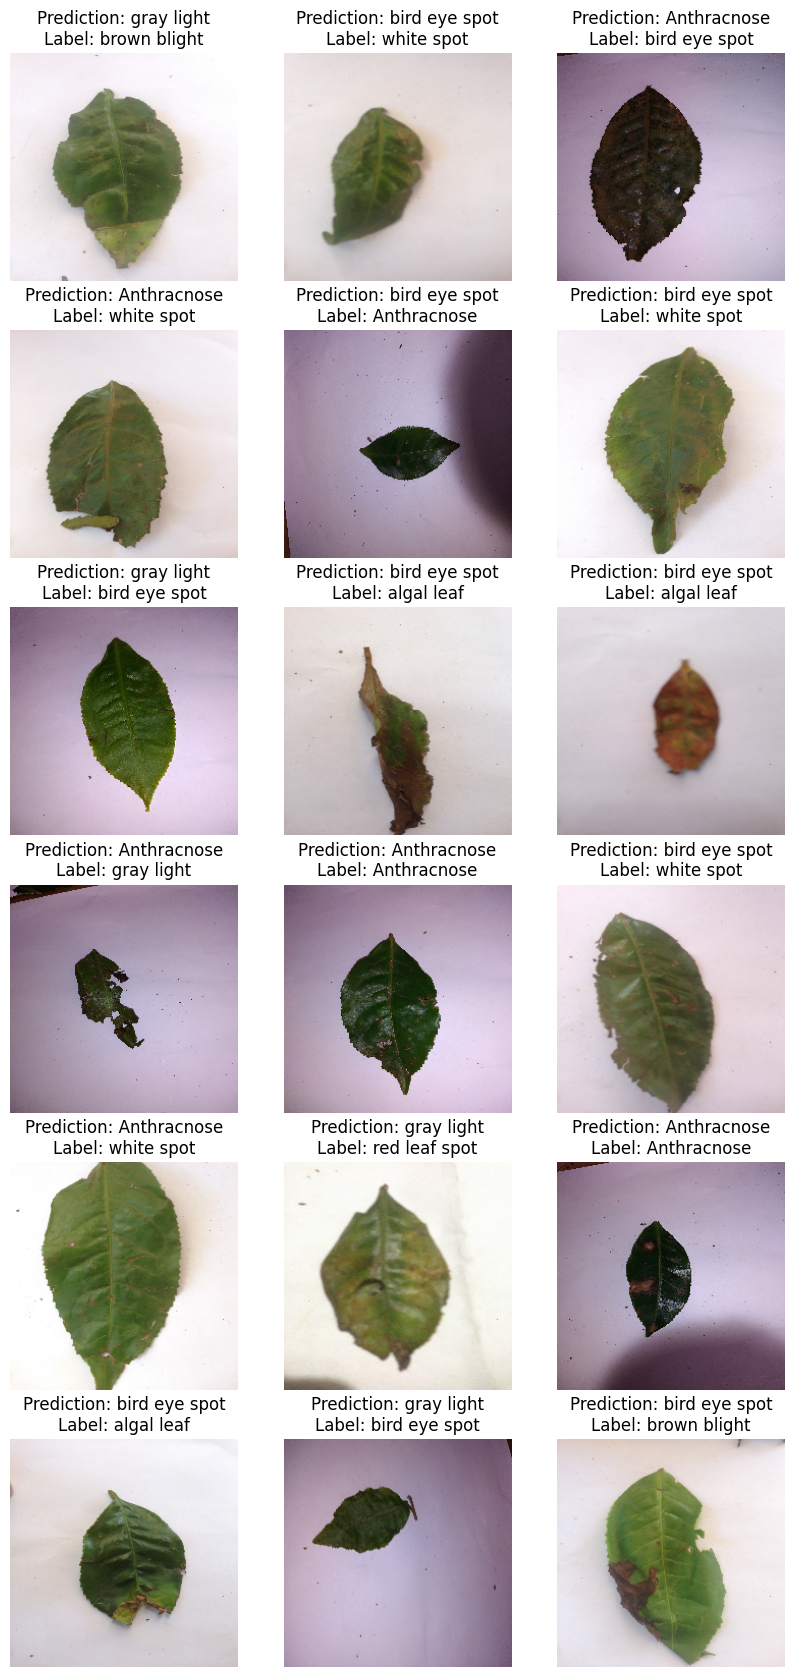

In [ ]:
# Retrieve a batch of images from the test set
image_batch, label_batch = val_ds.as_numpy_iterator().next()
predictions = resnet50_model.predict_on_batch(image_batch)

class_predictions = []
for i in predictions:
    class_prediction = np.argmax(i)
    class_predictions.append(class_prediction)

class_predictions = np.array(class_predictions)
print('Predictions:\n', class_predictions)
print('Labels:\n', label_batch)
print()
print(classification_report(label_batch, class_predictions))

plt.figure(figsize=(10, 21))
for i in range(18):
    ax = plt.subplot(6, 3, i + 1)
    plt.imshow(image_batch[i].astype("uint8"))
    plt.title("Prediction: "+class_names[class_predictions[i]]+"\nLabel: "+class_names[label_batch[i]])
    plt.axis("off")

##The ResNet50 model shows a Testing accuracy of 13%

##CNN - 81%
##VGG16 - 50%
##ResNet50 - 13%

##Therefore best model for hosting on a web platform is the CNN Model in this case.